# Core Imports

In [1]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole

DIM = 300
ASPECT = 3/2
IPythonConsole.molSize = (int(ASPECT*DIM), DIM)   # Change image size

# Static Paths
RAW_DATA_PATH = Path('raw_monomer_data')
PROC_DATA_PATH = Path('processed_monomer_data')
RXN_FILES_PATH = Path('rxn_smarts')

# Inspecting expanded dataset

In [2]:
data_path = RAW_DATA_PATH / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
df = pd.read_csv(data_path)
df

,smiles_monomer,smiles_polymer_DP2,smiles_polymer_DP3,smiles_polymer_DP6,smiles_polymer_DP18,num_monomers,mechanism,Glass_Transition,Melt_Temp,Cp_solid_slope,...,log10_ElongBreak,YoungMod,Tensile_Strength,Density,log10_Permeability_CH4,log10_Permeability_CO2,log10_Permeability_N2,log10_Permeability_O2,log10_Permeability_H2,log10_Permeability_H2O
0,O=C(Cl)Cl.Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(...,O=C(Cl)Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(F)F...,O=C(Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(F)F)cc...,O=C(Cl)Oc1ccc(C(c2ccc(OC(=O)Oc3ccc(C(c4ccc(OC(...,O=C(Cl)Oc1ccc(C(c2ccc(OC(=O)Oc3ccc(C(c4ccc(OC(...,2,carbonate,176.000,NaN,NaN,...,NaN,NaN,NaN,1.479,0.017759,1.380211,0.225687,0.838849,NaN,NaN
1,C=CSCCC,CCCSCCC(C)SCCC,CCCSC(C)CC(SCCC)C(C)SCCC,CCCSCCC(CCC(SCCC)C(CCC(CCSCCC)SCCC)SCCC)SCCC,CCCSCCCC(CC(CC(SCCC)C(CC(CCC(SCCC)C(CC(CC(CCC(...,1,vinyl,NaN,NaN,NaN,...,NaN,NaN,NaN,1.021,NaN,NaN,NaN,NaN,NaN,NaN
2,C=C(C#N)C(=O)OCC,CCOC(=O)C(C#N)CC(C)(C#N)C(=O)OCC,CCOC(=O)C(C#N)CC(C#N)(CC(C)(C#N)C(=O)OCC)C(=O)OCC,CCOC(=O)C(C#N)CCC(C#N)(C(=O)OCC)C(C#N)(CC(C#N)...,CCOC(=O)C(C#N)CCC(C#N)(CC(C#N)(C(=O)OCC)C(C#N)...,1,vinyl,131.850,NaN,NaN,...,NaN,2200.0,NaN,1.224,NaN,NaN,NaN,NaN,NaN,NaN
3,C=C(C)c1ccccc1,CC(CC(C)(C)c1ccccc1)c1ccccc1,CC(CCC(C)(CC(C)c1ccccc1)c1ccccc1)c1ccccc1,CC(CCC(C)(CC(C)(CC(C)(c1ccccc1)C(C)(CCC(C)c1cc...,CC(CCC(C)(c1ccccc1)C(C)(CCC(C)(CC(C)(CC(C)(c1c...,1,vinyl,171.850,NaN,0.51,...,NaN,NaN,NaN,1.070,NaN,NaN,NaN,NaN,NaN,NaN
4,C=C(C)C(=O)OC1CCCCC1,CC(CCC(C)C(=O)OC1CCCCC1)C(=O)OC1CCCCC1,CC(CCC(C)(CC(C)C(=O)OC1CCCCC1)C(=O)OC1CCCCC1)C...,CC(CCC(C)(CC(C)(CC(C)(C(=O)OC1CCCCC1)C(C)(CCC(...,CC(CCC(C)(CC(C)(CC(C)(CC(C)(CC(C)(CC(C)(C(=O)O...,1,vinyl,104.350,NaN,NaN,...,NaN,NaN,NaN,1.100,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,NCCCCCCCN.O=C(O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)O,NCCCCCCCNC(=O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)O,O=C(O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)NCCCCCCCN...,NCCCCCCCNC(=O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)N...,NCCCCCCCNC(=O)CCCCCCCCCCSCCCCSCCCCCCCCCCC(=O)N...,2,amide,31.000,NaN,NaN,...,NaN,NaN,NaN,1.040,NaN,NaN,NaN,NaN,NaN,NaN
462,O=C(Cl)Cl.Oc1ccc(C2(c3ccc(O)cc3)CCCCCC2)cc1,O=C(Cl)Oc1ccc(C2(c3ccc(O)cc3)CCCCCC2)cc1,O=C(Cl)Oc1ccc(C2(c3ccc(OC(=O)Cl)cc3)CCCCCC2)cc1,O=C(Cl)Oc1ccc(C2(c3ccc(OC(=O)Oc4ccc(C5(c6ccc(O...,O=C(Cl)Oc1ccc(C2(c3ccc(OC(=O)Oc4ccc(C5(c6ccc(O...,2,carbonate,155.000,NaN,NaN,...,NaN,NaN,NaN,1.203,NaN,NaN,NaN,-0.119186,NaN,NaN
463,OCCCCO.O=C(O)CCCCC(=O)O,O=C(O)CCCCC(=O)OCCCCO,O=C(O)CCCCC(=O)OCCCCOC(=O)CCCCC(=O)O,O=C(O)CCCCC(=O)OCCCCOC(=O)CCCCC(=O)OCCCCOC(=O)...,O=C(O)CCCCC(=O)OCCCCOC(=O)CCCCC(=O)OCCCCOC(=O)...,2,ester,-43.050,57.4,NaN,...,NaN,NaN,16.2,1.060,NaN,NaN,NaN,NaN,NaN,NaN
464,O=C1OC(=O)c2cc(-c3ccc4c(c3)C(=O)OC4=O)ccc21.Nc...,Nc1ccc(Oc2ccc(C(c3ccc(Oc4cccc(Oc5ccc(C(c6ccc(O...,Nc1ccc(Oc2ccc(C(c3ccc(Oc4cccc(Oc5ccc(C(c6ccc(O...,Nc1ccc(Oc2ccc(C(c3ccc(Oc4cccc(Oc5ccc(C(c6ccc(O...,Nc1ccc(Oc2ccc(C(c3ccc(Oc4cccc(Oc5ccc(C(c6ccc(O...,2,imide,285.000,NaN,NaN,...,NaN,NaN,NaN,1.316,NaN,NaN,NaN,NaN,NaN,NaN


## Filtering by substructure query

In [8]:
from rdkit.Chem import rdqueries


halogen_query = Chem.MolFromSmarts('[X]')
halogen_query.GetAtomWithIdx(0).SetQuery(rdqueries.XAtomQueryAtom())

metal_query = Chem.MolFromSmarts('[X]')
metal_query.GetAtomWithIdx(0).SetQuery(rdqueries.MAtomQueryAtom())

sulfur_query  = Chem.MolFromSmarts('[S]')
silicon_query = Chem.MolFromSmarts('[Si]')

vinyl 23


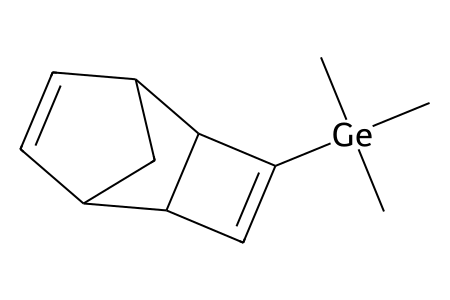

vinyl 223


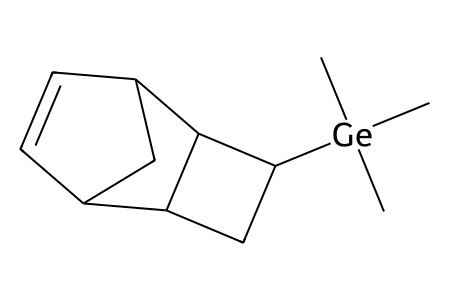

In [9]:
all_elems = set()
target_query = silicon_query
target_query = metal_query

for i, row in df.iterrows():
    smiles = row['smiles_monomer']
    mol = Chem.MolFromSmiles(smiles)
    elems = set(
        atom.GetSymbol()
            for atom in mol.GetAtoms()
    )

    if mol.HasSubstructMatch(target_query):
        print(row['mechanism'], i)
        display(mol)

    all_elems |= elems

## Sorting by polymerization mechanism

In [ ]:
key = 'mechanism'

gb = df.groupby(key)
counts = gb.size().to_dict()
frames = {
    mech : gb.get_group(mech)
        for mech in gb.groups
}

plt.bar(counts.keys(), counts.values())
plt.title(f'Number of SMILES by {key}')

In [ ]:
sum(i for i in counts.values())

In [ ]:
for mech, frame in frames.items():
    print(mech, frame['num_monomers'].unique())

In [ ]:
# frame = frames['ester']
# frame = frames['carbonate']
# frame = frames['amide']
# frame = frames['imide']
# frame = frames['urethane']
frame = frames['vinyl']
ids = (23, 223)

spacer = '=' * 25

test = defaultdict(list)
smaller = set()
for idx, row in frame.iterrows():
    if idx in ids:
        monomer_smiles = row['smiles_monomer']
        monomer = Chem.MolFromSmiles(monomer_smiles)
        display(monomer)

        dimer_smiles = row['smiles_polymer_DP2']
        dimer = Chem.MolFromSmiles(dimer_smiles)
        display(dimer)

        trimer_smiles = row['smiles_polymer_DP3']
        trimer = Chem.MolFromSmiles(trimer_smiles)
        display(trimer)

        num_monos = row['num_monomers']
        frags = Chem.GetMolFrags(monomer, asMols=True)
        count_monos = len(frags)
        assert(num_monos == count_monos) # sanity check

        test[count_monos].append(monomer)
        print(f'{spacer} {row["mechanism"]}-{idx} {spacer}')

In [ ]:
display(Chem.MolFromSmiles(frame.loc[7].smiles_monomer))
display(Chem.MolFromSmiles(frame.loc[7].smiles_polymer_DP2))
display(Chem.MolFromSmiles(frame.loc[7].smiles_polymer_DP3))

In [ ]:
frame

# Preprocessing and cleaning up NREL Urethane data

## Loading and inspecting raw data

In [ ]:
p = RAW_DATA_PATH / 'nipu_urethanes.xlsx'
raw_table = pd.read_excel(p) # load from .xlsx file
raw_table['Monomers'] = raw_table['Monomers'].apply(literal_eval) # convert string of tuples into proper tuples

nipus     = raw_table[raw_table['Chemistry'] == 'NIPU'    ]
urethanes = raw_table[raw_table['Chemistry'] == 'urethane']

nipus_mono     = nipus['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order
urethanes_mono = urethanes['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order

In [ ]:
raw_table

In [ ]:
# targ_mono = nipus_mono
targ_mono = {}

for i, monos in targ_mono.items():
    try:
        mono1, mono2 = monos
        display(Chem.MolFromSmiles(mono1))
        
        print('='*50)
    except ValueError:
        print(f'Row {i} failed')

## Classify each monomer pair by respective reactive functional group

In [ ]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('r') as fn_group_file:
    fn_group_SMARTS = json.load(fn_group_file)
    fn_groups = {
        group_name : Chem.MolFromSmarts(SMARTS)
            for group_name, SMARTS in fn_group_SMARTS.items()
    }

reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

all_results = []
digroup_only_results = []
for i, (chemistry, monomer_pair) in raw_table.iterrows():
    monomer_entry = {
        'Chemistry' : chemistry
    }

    too_many_sites = False
    for SMILES in monomer_pair:
        rdmol = Chem.MolFromSmiles(SMILES)
        rdmol = Chem.AddHs(rdmol)
        Chem.Kekulize(rdmol, clearAromaticFlags=True) # ensure aromatic rings are treated as simply single-double (simplifies structure matching)

        for group_name, fn_group in fn_groups.items():
            matches = rdmol.GetSubstructMatches(fn_group)
            if matches and (group_name in reaction_pairs[chemistry]):
                monomer_entry[group_name] = Chem.MolToSmarts(rdmol)
            too_many_sites |= (len(matches) > 2) # OR with previous result; single true will make result true
        
    all_results.append(monomer_entry)
    if not too_many_sites:        
        digroup_only_results.append(monomer_entry)

## Save to csv files for future reference

In [ ]:
all_table = pd.DataFrame.from_records(all_results)
digroup_only_table = pd.DataFrame.from_records(digroup_only_results)

all_table.to_csv(PROC_DATA_PATH / 'clean_smarts_all.csv')
digroup_only_table.to_csv(PROC_DATA_PATH / 'clean_smarts_digroup.csv')